In [1]:
import matplotlib.pyplot as plt

import pyspark.sql
from pyspark.ml.feature import Tokenizer, HashingTF, IDF, Word2Vec
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [2]:
#constants

NUM_FEATURES_RANGE = range(1, 102, 10)

In [3]:
spark = pyspark.sql.SparkSession.builder \
        .master("local[4]") \
        .appName("HW_5") \
        .getOrCreate()

22/12/16 21:12:39 WARN Utils: Your hostname, kirill-Lenovo-Legion-5-15ARH05H resolves to a loopback address: 127.0.1.1; using 192.168.178.21 instead (on interface wlp4s0)
22/12/16 21:12:39 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/12/16 21:12:40 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
train = spark.read.option("header",True).option("quote", "\"").option("escape", "\"") \
    .option("multiline", True).option("inferSchema", True).csv("data/train.csv")
test = spark.read.option("header",True).option("quote", "\"").option("escape", "\"") \
    .option("multiline", True).option("inferSchema", True).csv("data/test.csv")
test_labels = spark.read.option("header",True).option("quote", "\"").option("escape", "\"") \
    .option("multiline", True).option("inferSchema", True).csv("data/test_labels.csv")
test = test.join(test_labels, 'id')

# Блок 1. HashingTF и IDF

In [5]:
tokenizer = Tokenizer(inputCol="comment_text", outputCol="tokens")

In [6]:
def fitTFIDF(numFeatures: int, target: str):
    hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="featuresTF", numFeatures=numFeatures)
    idf = IDF(inputCol=hashingTF.getOutputCol(), outputCol="featuresIDF")
    model_lr = LogisticRegression(featuresCol=idf.getOutputCol(), labelCol=target)
    pipeline = Pipeline(stages=[tokenizer, hashingTF, idf, model_lr])
    fitted_pipeline = pipeline.fit(train)
    evaluator = BinaryClassificationEvaluator(labelCol=model_lr.getLabelCol(), \
                                              rawPredictionCol=model_lr.getRawPredictionCol())
    return evaluator.evaluate(fitted_pipeline.transform(test))


def get_results_TFIDF(target: str, numFeaturesRange: int):
    score = []
    for numFeatures in numFeaturesRange:
        score.append(fitTFIDF(numFeatures, target))
    return score


def get_all_results(targets):
    for target in targets.keys():
        targets[target] = get_results_TFIDF(target, NUM_FEATURES_RANGE)
    return targets

In [7]:
targets_dict = {"toxic": [], "severe_toxic": [], "obscene": [], "threat": [], "insult": [], "identity_hate": []}

tfidf_result = get_all_results(targets_dict)

22/12/16 21:13:34 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
22/12/16 21:13:34 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [9]:
def plot_results(result, feature_range):
    for key in result.keys():
        plt.plot(feature_range, result[key], label = key)
    plt.legend()
    plt.grid()
    plt.xlabel("numFeatures")
    plt.ylabel("AUC ROC")
    plt.show()

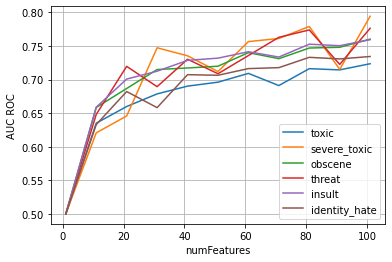

In [10]:
plot_results(tfidf_result, NUM_FEATURES_RANGE)

По графику видно, что в связи с ростом numFeatures AUC ROC растет для всех таргетов

# Блок 2. Word2Vec

In [11]:
targets_dict = {"toxic": 0, "severe_toxic": 0, "obscene": 0, "threat": 0, "insult": 0, "identity_hate": 0}

w2v = Word2Vec(inputCol=tokenizer.getOutputCol(), outputCol="featuresW2V", vectorSize=32)

for target in targets_dict.keys():
    model_lr = LogisticRegression(featuresCol=w2v.getOutputCol(), labelCol=target)
    evaluator = BinaryClassificationEvaluator(labelCol=model_lr.getLabelCol(), rawPredictionCol=model_lr.getRawPredictionCol())
    pipeline = Pipeline(stages=[tokenizer, w2v, model_lr])
    fitted_pipeline = pipeline.fit(train)
    targets_dict[target] = evaluator.evaluate(fitted_pipeline.transform(test))

In [12]:
targets_dict

{'toxic': 0.837953621215846,
 'severe_toxic': 0.9301843986372952,
 'obscene': 0.8683343368802013,
 'threat': 0.9059904812936591,
 'insult': 0.8592416980872052,
 'identity_hate': 0.8857609667231405}

Word2Vec работает лучше для всех таргетов при выбранном vectorSize = 32